# 0. Preliminary configuration

Install needed packages

In [2]:
%%capture dependency_install_output

!pip install -r requirements.txt

Constants for the whole notebook:

In [1]:
# Wether to use ECG data with original sampling frequency (500Hz) or downsampled data (100Hz)
DOWNSAMPLED_DATA = True
DATA_DIRECTORY_NAME = 'data/physionet.org/files/ptb-xl/1.0.2/' 

Download data if needed using the provided script. The download will take a while
so **do not execute next cell if data is alreadyd downloaded**.

In [46]:
%%capture download_output

# Download if needed using the provided script. The download will take a while
# so do not execute this cell if data is alreadyd downloaded
!pushd data ; bash download_data.sh ; popd

# 1. Data preparation and description

Load data from files based on the example given in the dataset files

In [3]:
import pandas as pd
import numpy as np
import wfdb
import ast

def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

path = DATA_DIRECTORY_NAME
sampling_rate = 100 if DOWNSAMPLED_DATA else 500

# load and convert annotation data
Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

# Load raw signal data
X = load_raw_data(Y, sampling_rate, path)

# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

# Apply diagnostic superclass
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

## 1.1. Labels

Labels in this dataset are the diagnosis for each record. Labels are given in the _scp_codes_ as a dictionary, that also contains a likelyhood for each one. according to the dataset documentation when the likelyhood is 0 it does not mean that the diagnosis is not present for that record, but that the probability is unknown. One example of such dictionaries:

In [5]:
Y.scp_codes.iloc[0]

{'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}

Diagnoses are aggregated in five super-classes. As not all diagnosis have a superclass equivalent, some records do not have a superclass. Also, some records may have more than one superclass. Transforming the current list of superclasses of each record into five one-hot-encoding colums can help us check these facts and how many records for each super-class we have.

In [6]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer(sparse_output=True)

Y = Y.join(pd.DataFrame.sparse.from_spmatrix(
                mlb.fit_transform(Y['diagnostic_superclass']),
                index=Y.index,
                columns=mlb.classes_)
          )

In [7]:
superclasses = ['NORM', 'STTC', 'HYP', 'MI', 'CD']

total_records = len(Y)
print("Total records:", total_records)

for superclass in superclasses:
    superclass_records = Y[superclass].sum()
    print(f"{superclass} records:", superclass_records, ":", superclass_records/total_records*100, "%")

several_sup_records = len(Y[Y.CD + Y.HYP + Y.MI + Y.NORM + Y.STTC > 1])
print("Records with several superclasses: ", several_sup_records, ":", several_sup_records/total_records*100, "%")
no_sup_records = len(Y[Y.CD + Y.HYP + Y.MI + Y.NORM + Y.STTC == 0])
print("Records with no superclasses: ", no_sup_records, ":", no_sup_records/total_records*100, "%")

Total records: 21801
NORM records: 9517 : 43.65396082748498 %
STTC records: 5237 : 24.02183386083207 %
HYP records: 2649 : 12.150818769781202 %
MI records: 5473 : 25.104353011329756 %
CD records: 4901 : 22.48062015503876 %
Records with several superclasses:  5148 : 23.613595706618963 %
Records with no superclasses:  405 : 1.857712948947296 %


. We can see that the predominant superclass is the normal ECG. The STTC, MI and CD have a similar representation in the dataset. When treating with balance problems, the class that might represent a biggest issue might the hypertrophy (HYP) class. 

. There is a very small amount of records with no superclass that might be used in classification as an extra label, but taking into account the imbalance and the possible dispersion of the class, the best option might be to delete these records before training. 

. The percentage of records that have more than one superclass is considerable. This might mean that there are diagnosis that appear together frequently. We can check the amounts of the existing combinations. To do that we sort the superclass lists in the Y dataframe to delete duplications because of the order of the classes.

In [8]:
Y['diagnostic_superclass'] = Y['diagnostic_superclass'].apply(sorted)
Y['diagnostic_superclass'].value_counts()

diagnostic_superclass
[NORM]                 9072
[MI]                   2532
[STTC]                 2401
[CD]                   1708
[CD, MI]               1300
[HYP, STTC]             781
[MI, STTC]              600
[HYP]                   535
[CD, STTC]              471
[CD, NORM]              407
[]                      405
[HYP, MI, STTC]         361
[CD, HYP]               300
[CD, MI, STTC]          223
[CD, HYP, STTC]         211
[HYP, MI]               183
[CD, HYP, MI, STTC]     156
[CD, HYP, MI]           117
[NORM, STTC]             28
[CD, NORM, STTC]          5
[CD, HYP, NORM]           2
[HYP, NORM]               2
[CD, HYP, MI, NORM]       1
Name: count, dtype: int64

As we can see, the HYP class appears more frequently paired with STTC that by itself. Other pairings are very frequent too, with CD for example having more paired appareances than appareances by itsel, specially with MI. Three or more classes for the same records is less frequent, but there is a non-negligible amount under these conditions. Having this information into account might be useful because if a diagnosis is made, its more frequent pairings should be taken into account.

## 1.2. Metadata

Lets see some basic information of the most relevant metadata columns and the loss values.

In [9]:
exclude_columns = ['diagnostic_superclass', 'CD', 'HYP', 'MI', 'NORM', 'STTC', 'patient_id', 'strat_fold', 'scp_codes']

In [10]:
Y.drop(exclude_columns, axis=1).describe(include=np.number)

,age,sex,height,weight,nurse,site,validated_by
count,21801.000000,21801.000000,6975.000000,9422.000000,20326.000000,21783.000000,12421.000000
mean,62.769781,0.479106,166.703226,70.996391,2.291745,1.545012,0.746075
std,32.307421,0.499575,10.866804,15.878365,3.254033,4.172799,1.178003
min,2.000000,0.000000,6.000000,5.000000,0.000000,0.000000,0.000000
25%,50.000000,0.000000,160.000000,60.000000,0.000000,0.000000,0.000000
50%,62.000000,0.000000,166.000000,70.000000,1.000000,1.000000,1.000000
75%,72.000000,1.000000,174.000000,80.000000,3.000000,2.000000,1.000000
max,300.000000,1.000000,209.000000,250.000000,11.000000,50.000000,11.000000


In [11]:
Y.drop(exclude_columns, axis=1).describe(include=['O'])

,device,recording_date,report,heart_axis,infarction_stadium1,infarction_stadium2,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,filename_lr,filename_hr,r_peaks
count,21801,21801,21801,13331,5613,103,1599,3260,613,30,1949,291,21801,21801,21801
unique,11,21795,9888,8,6,3,318,124,103,14,128,4,21801,21801,21799
top,CS100 3,1992-02-06 11:47:42,sinus rhythm. normal ecg.,MID,unknown,Stadium III,", V6",", I-AVR,",alles,V6,1ES,"ja, pacemaker",records100/00000/00001_lr,records500/00000/00001_hr,[ 91 182 270 357 449 539 630 721 810 899 989]
freq,6140,2,1734,7687,3431,65,221,953,140,8,405,285,1,1,2


The dataset documentation specifies that for privacy purposes, all ages above 89 are changed to 300. A good approximation to the real data can be changing all ages of 300 to 90. We can then see a more accurate statistical description of the age variable.

In [12]:
Y.loc[Y['age'] == 300, 'age'] = 90

In [13]:
Y['age'].describe()

count    21801.000000
mean        59.947434
std         17.010876
min          2.000000
25%         50.000000
50%         62.000000
75%         72.000000
max         90.000000
Name: age, dtype: float64

With this data we can see that we have a wide representation in terms of age and balanced in sex. Lets check lost values:

In [14]:
sorted_missing_percentages = ((Y.isnull().sum() / len(Y)) * 100).sort_values(ascending=False)
sorted_missing_percentages[sorted_missing_percentages > 0]

electrodes_problems    99.862392
infarction_stadium2    99.527545
pacemaker              98.665199
burst_noise            97.188202
baseline_drift         92.665474
extra_beats            91.060043
static_noise           85.046557
infarction_stadium1    74.253475
height                 68.006055
weight                 56.781799
validated_by           43.025549
heart_axis             38.851429
nurse                   6.765745
site                    0.082565
dtype: float64

The highest missing percentages correspond to variables in which the missing value means no pressence of the column (no electrode problems, no infaction stadium, no pacemaker...). The _site_ and _nurse_ variables lost percentage might not be impotant, but the _height_, _weight_ and _heart_axis_ variables have a considerable amount of loss records.

We can also check the correlation between numerical metadata:

In [15]:
correlation_df = Y.drop(exclude_columns, axis=1).corr(numeric_only=True)

<Axes: >

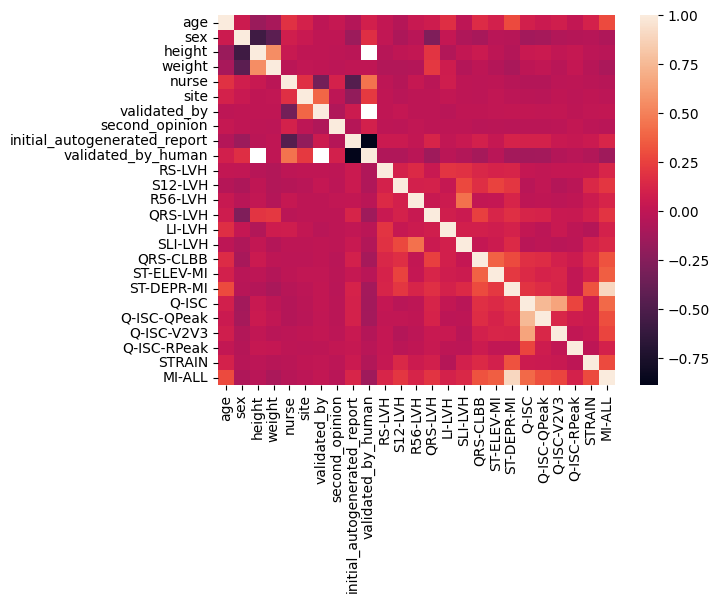

In [16]:
import seaborn as sns
sns.heatmap(correlation_df)

No relevant unexpected information is obtained from this representation.

# 2. ECG plot

The way to plot a 12-lead ECG is something that could be agreed with experts that will use the graphic representation. However, a quick seacrch on the internet shows that a common representation is a 4x3 grid of graphics, in this order:

|     |     |    |    |
|-----|-----|----|----|
| I   | aVR | V1 | V4 |
| II  | aVL | V2 | V5 |
| III | aVF | V3 | V6 |

That is the plot we will try to replicate. Following the [extended documentation](https://www.researchgate.net/publication/341618371_PTB-XL_a_large_publicly_available_electrocardiography_dataset) of the dataset, the leads are in order I, II, III, aVL, aVR, aVF, V1, V2, V3, V4, V5, V6.

In [3]:
position = [0, 4, 6, 9, 1, 3, 2, 6, 10, 3, 7, 11]
names_and_positions = [('I', 0), 
                       ('aVR', 4), 
                       ('V1', 6),
                       ('V4', 9),
                       ('II', 1),
                       ('aVL', 3),
                       ('V2', 7),
                       ('V5', 10),
                       ('III', 2),
                       ('aVF', 5),
                       ('V3', 8),
                       ('V6', 11)]

In [11]:
import matplotlib.pyplot as plt


def plot_12_lead(data):
    
    #plt.style.use('fivethirtyeight')
    fig, axes = plt.subplots(3, 4, figsize=(40, 8))
    axes = axes.ravel()
    for i, ax in enumerate(axes):
        ax.plot(data[:, names_and_positions[i][1]])
        ax.set_title(names_and_positions[i][0])
        ax.set_xticks([])
    # Adjust spacing between subplots
    plt.tight_layout()
    plt.show()

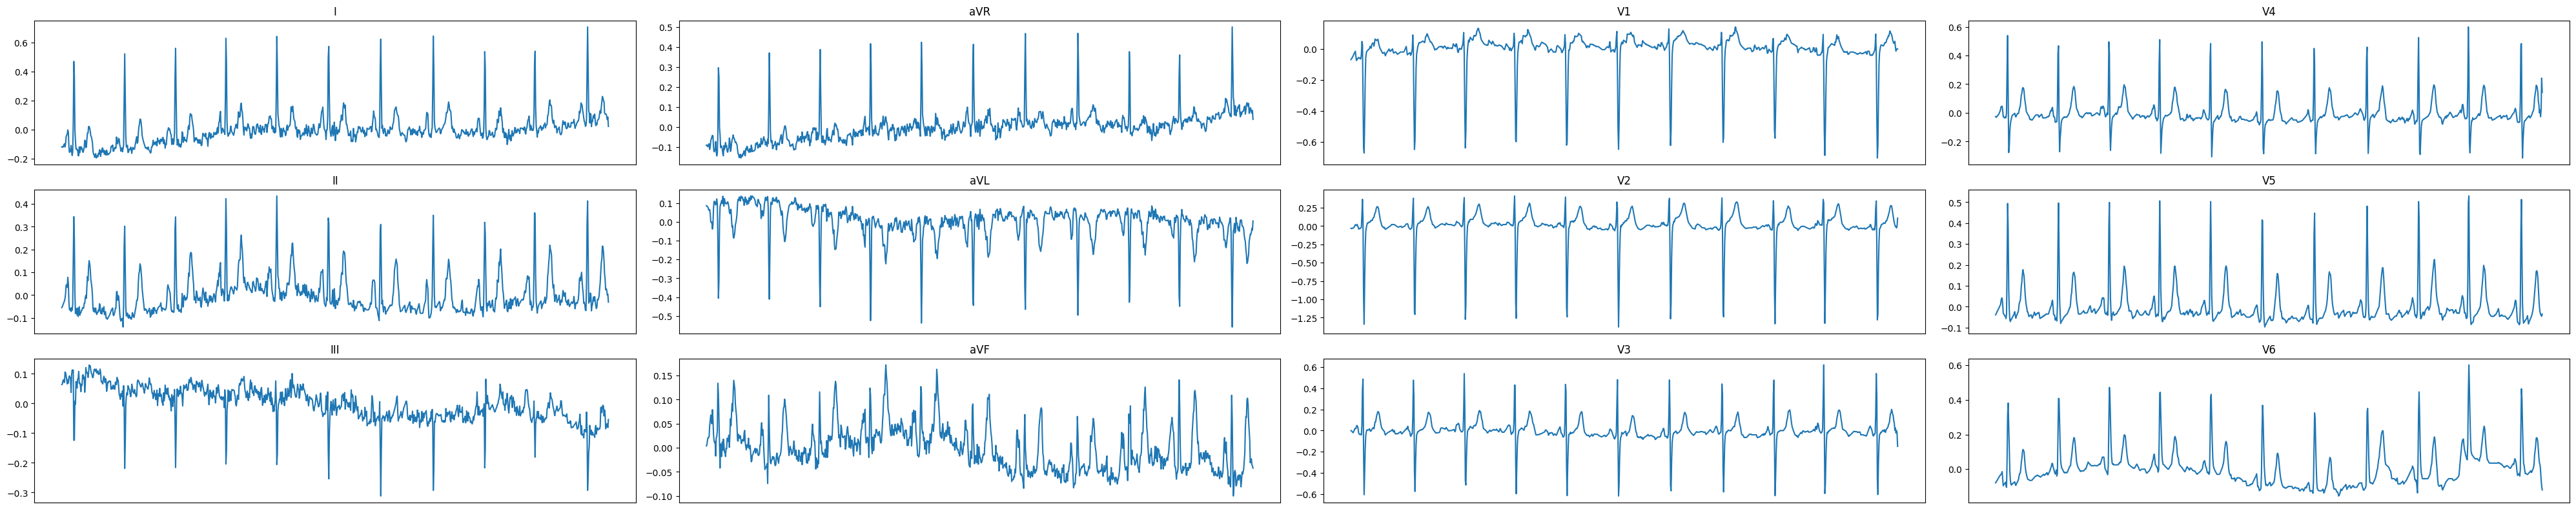

In [68]:
plot_12_lead(X[0])

If the image in the notebook is too small to be seen clearly, by double clicking on it can be seen at full size (if using JupyterLab). However, if this layout is not readeable enough for the expert, it can be changed to longest plots with less plots per row. Or if the complete ECG data is not needed for diagnosis, it could be cut for a more readable plot:

In [85]:
def plot_12_lead_half_ecg(data):
    
    fig, axes = plt.subplots(3, 4, figsize=(40, 8))
    axes = axes.ravel()
    for i, ax in enumerate(axes):
        ax.plot(data[:len(data)//2, names_and_positions[i][1]])
        ax.set_title(names_and_positions[i][0])
        ax.set_xticks([])
    plt.tight_layout()
    plt.show()

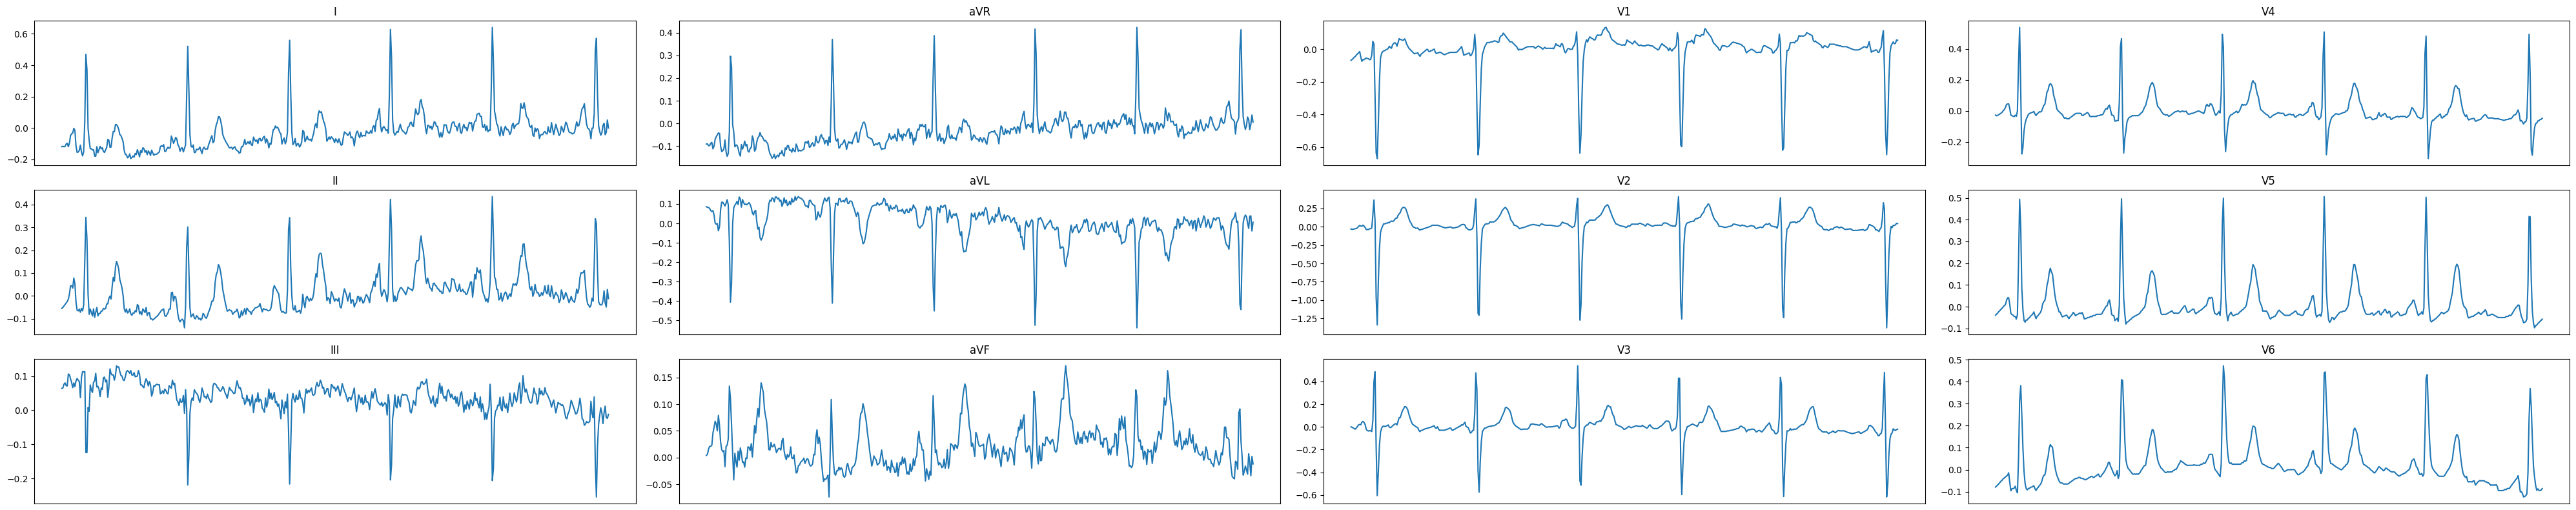

In [70]:
plot_12_lead_half_ecg(X[0])

There are more options that could make the plot more readable, like adding a grid, changing colour of the plot... These options should be discussed with the expert.

# 3. ECG sygnal analysis

There are several Python packages that give us tools to analyze ECG sygnals. A comparison of some of them can be found [here](https://www.samproell.io/posts/signal/ecg-library-comparison/). The decision of which one should be used depends on many factors: functionalities needed, efficiency requisites... We have already used wfbd to read the data, but [NeuroKit2](https://neuropsychology.github.io/NeuroKit/functions/ecg.html) provides more functionalities to be explored, so we will it in this section. For almost all processes the package implements several algorithms. Here we will always be using the by default algorithms, but an informed selection of the algorithm would be ideal.

In [4]:
import neurokit2 as nk

First we will create a function to easily access to the desired ECG by position in the dataset and to the desired lead in that ECG by name.

In [5]:
LEAD_ORDER = {name: position for position, name in enumerate(['I', 'II', 'III', 'aVL', 'aVR', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'])}

def get_signal(dataset, dataset_position, lead_name):
    return X[dataset_position][:, LEAD_ORDER[lead_name]]

Neurokit2 has a default processing pipeline for ECG and a plot that has a lot of information but is pretty hard to read, so we will analyze the signal step by step. 

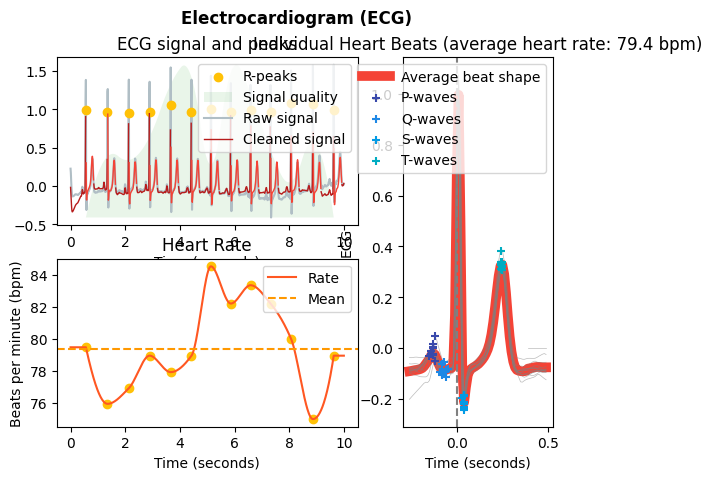

In [6]:
chosen_ecg_signal = get_signal(X, 42, 'II')
signals, info = nk.ecg_process(chosen_ecg_signal, sampling_rate=sampling_rate)
nk.ecg_plot(signals, info)

## 3.1. Heart beat

We will use R peaks to count heartbeats in the signal, as there is one for each heartbeat. The location of the peaks is already computed:

In [7]:
info['ECG_R_Peaks']

array([ 56, 135, 213, 289, 366, 442, 513, 586, 658, 731, 806, 886, 962])

Using these peaks we can obtain mean heart rate

In [8]:
ecg_rate = nk.signal_rate(signals, sampling_rate=100, desired_length=len(signals))
print("Mean heart rate: ", np.mean(ecg_rate))

Mean heart rate:  79.39025111166428


They can be visualized in over the signal, including total heartbeats and average heart rate

In [14]:
def plot_r_peaks(signal):
    signals, info = nk.ecg_process(chosen_ecg_signal, sampling_rate=sampling_rate)
    peak_locations = info['ECG_R_Peaks']
    fig = plt.figure(figsize=(25, 6))
    plt.plot(signal)
    peak_values = signal[peak_locations]
    plt.scatter(peak_locations, 
                peak_values, 
                marker='o', 
                color='red', 
                label='R peak')
    tick_labels = [i*100 for i in range(len(signal)//sampling_rate+1)]
    ticks = [tick//sampling_rate for tick in tick_labels]
    plt.xticks(tick_labels, ticks)
    plt.legend()
    plt.ylabel("μV/LSB")
    plt.xlabel("s")
    plt.grid(True)
    mean_rate = np.mean(nk.signal_rate(signals, sampling_rate=100, desired_length=len(signals)))
    heart_beats = len(info['ECG_R_Peaks'])
    plt.title(f'total heart beats: {heart_beats}, average heart rate: {mean_rate}')
    plt.show()

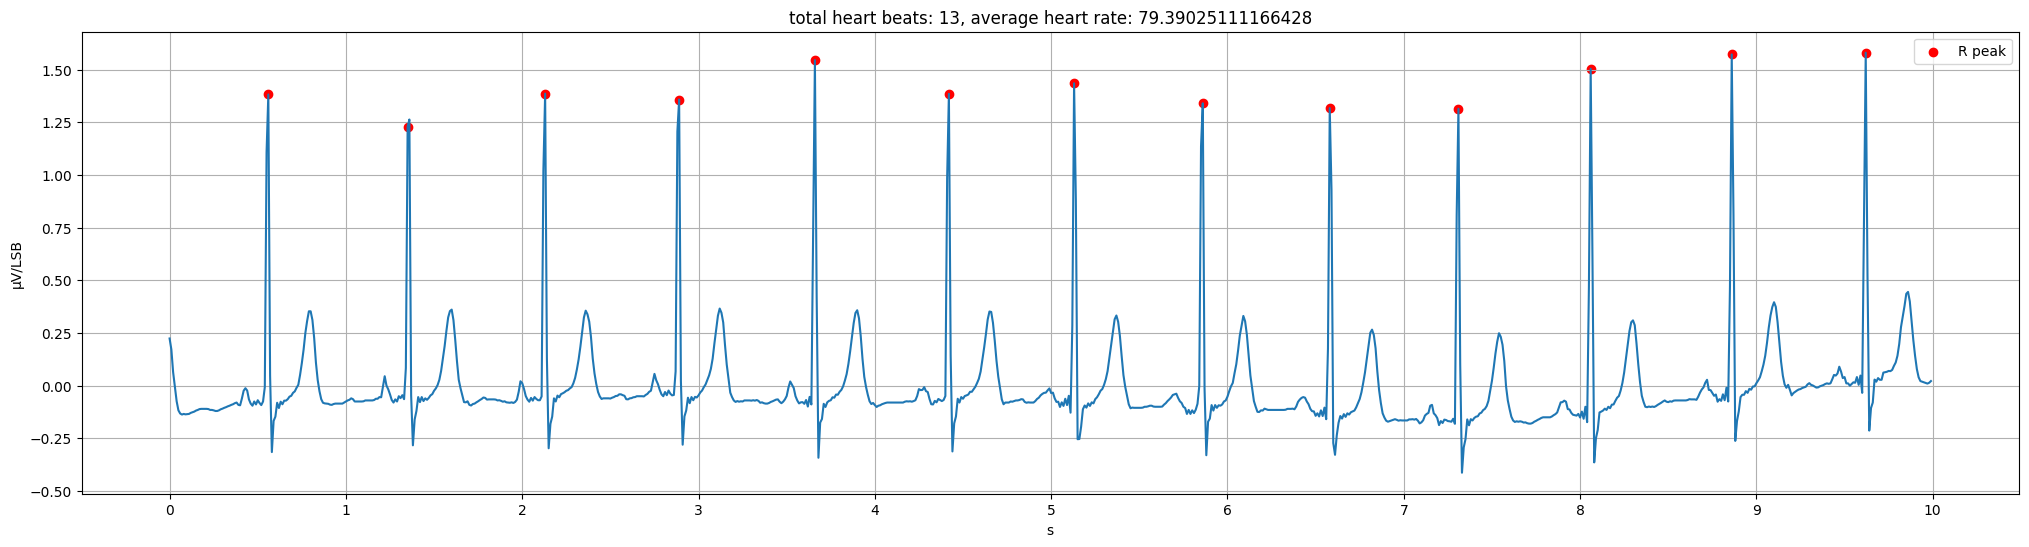

In [15]:
plot_r_peaks(chosen_ecg_signal)

Signal can be cleaned of noise

In [18]:
cleaned = nk.ecg_clean(chosen_ecg_signal, sampling_rate=sampling_rate)

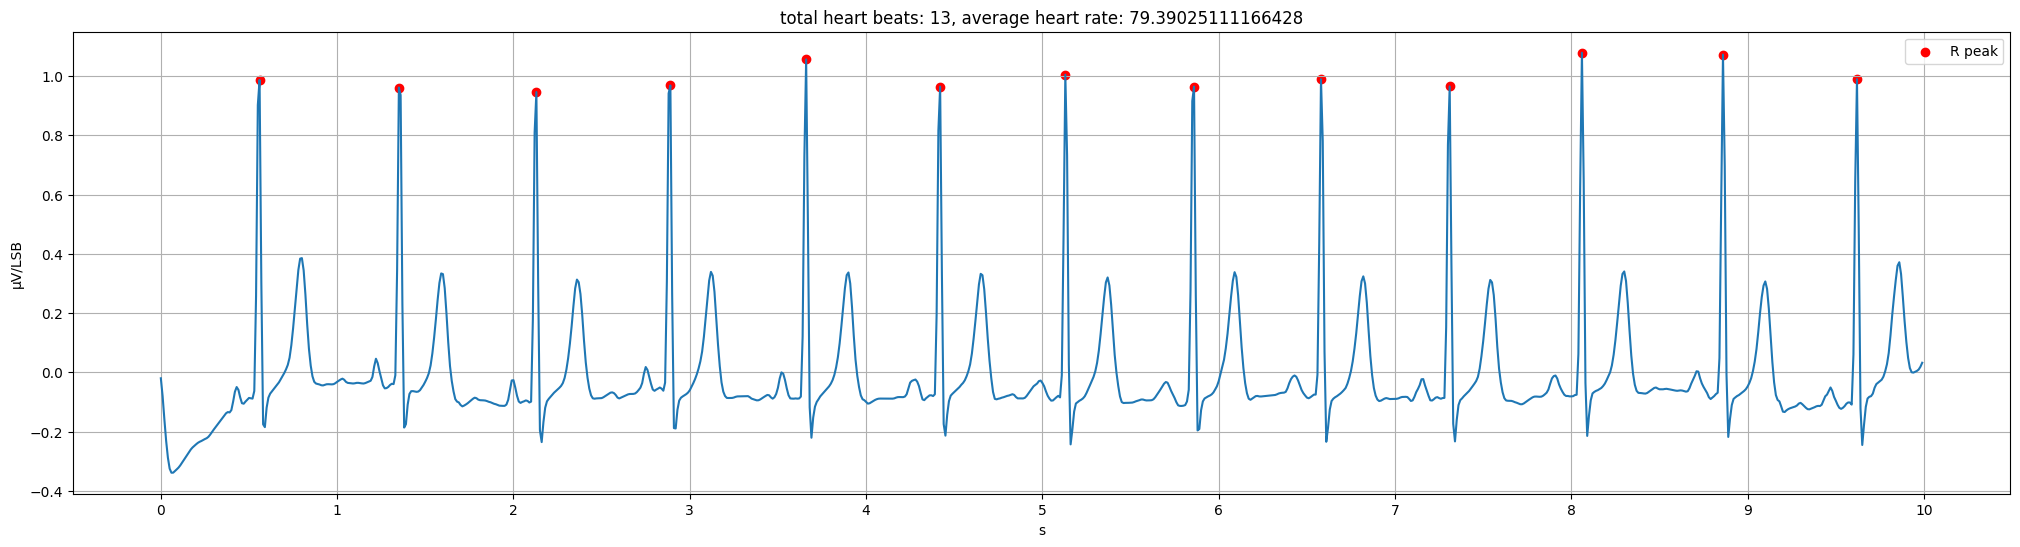

In [19]:
plot_r_peaks(cleaned)

## 3.2. Complex QRS

Using NeuroKit we can also detect the rest of complex QRS, and we can annotate it over the signal in a similar way we did for R peaks

In [20]:
import math

In [23]:
def plot_complex_qrs_peaks(signal):
    signals, info = nk.ecg_process(chosen_ecg_signal, sampling_rate=sampling_rate)
    peaks = [('R', [i for i in info['ECG_R_Peaks'] if not math.isnan(i)]),
                 ('P', [i for i in info['ECG_P_Peaks'] if not math.isnan(i)]),
                 ('Q', [i for i in info['ECG_Q_Peaks'] if not math.isnan(i)]),
                 ('S', [i for i in info['ECG_S_Peaks'] if not math.isnan(i)]),
                 ('T', [i for i in info['ECG_T_Peaks'] if not math.isnan(i)])]
    fig = plt.figure(figsize=(25, 6))
    plt.plot(signal)
    
    colors = ['b', 'g', 'r', 'c', 'm']
    
    for color, peak_inf in zip(colors, peaks):
        peak_values = signal[peak_inf[1]]
        plt.scatter(peak_inf[1], 
                    peak_values, 
                    marker='o', 
                    color=color, 
                    label=f'{peak_inf[0]} peak')
        
    tick_labels = [i*100 for i in range(len(signal)//sampling_rate+1)]
    ticks = [tick//sampling_rate for tick in tick_labels]
    plt.xticks(tick_labels, ticks)
    plt.legend()
    plt.ylabel("μV/LSB")
    plt.xlabel("s")
    plt.grid(True)
    mean_rate = np.mean(nk.signal_rate(signals, sampling_rate=100, desired_length=len(signals)))
    plt.show()

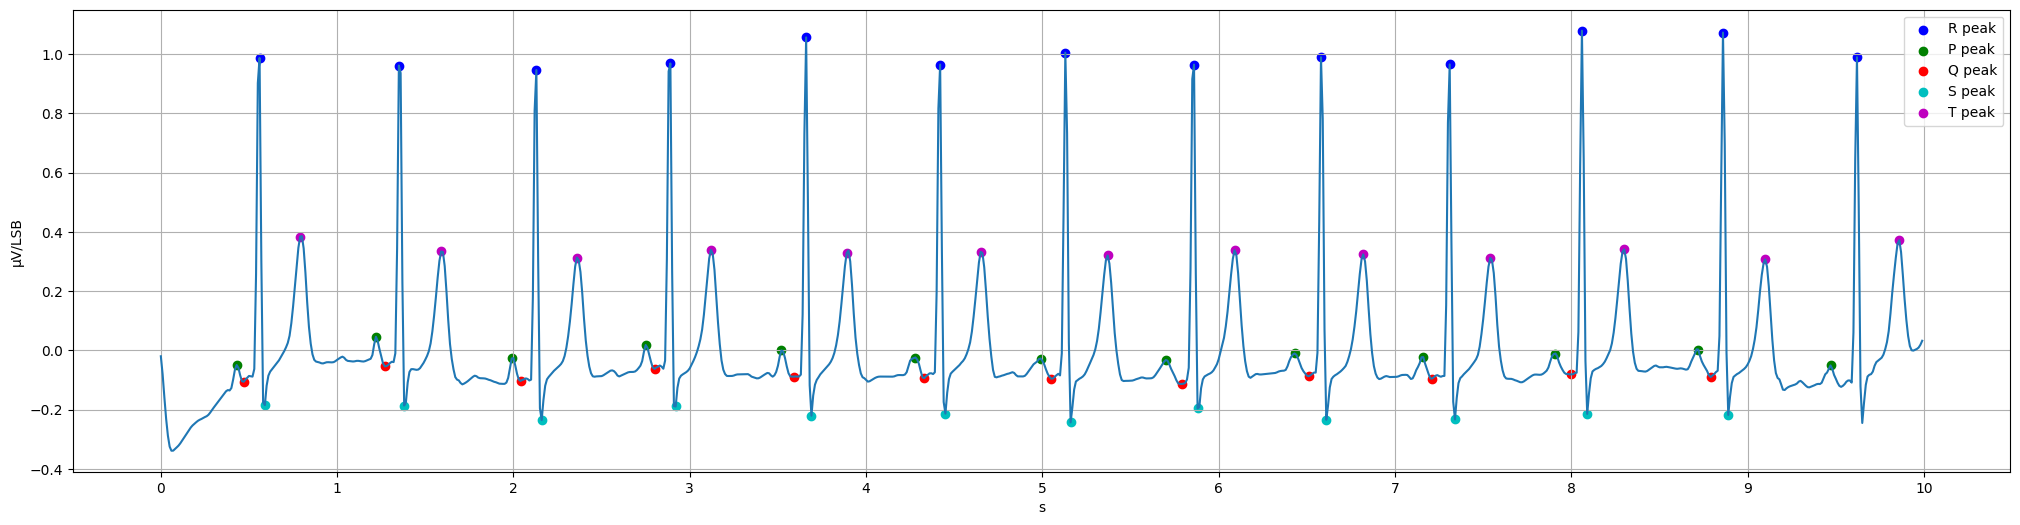

In [24]:
plot_complex_qrs_peaks(cleaned)

As we can see, in this example one S-peak and one Q-peak are not detected. 

## 3.3. Cardiac phase

We can obtain the cardiac phase of each point of the signal, and plot it together with the signal. In this case we plot in blue the systole and in red the dyastole

In [27]:
def transition_positions(phases):
    transition_positions = []

    # Iterate through the list
    for i in range(1, len(phases)):
        if phases[i - 1] != phases[i] and (not math.isnan(phases[i-1]) or not math.isnan(phases[i])):
            transition_positions.append(i)
            
    return transition_positions

In [28]:
def plot_cardiac_phase(signal):
    signals, info = nk.ecg_process(chosen_ecg_signal, sampling_rate=sampling_rate)
    fig, ax = plt.subplots(figsize=(25, 6))

    #fig = plt.figure(figsize=(25, 6))
    ax.plot(signal)
    
    phase = signals['ECG_Phase_Ventricular'].to_numpy()
    transitions = transition_positions(phase)
    
    current_color = 'r'
    current_label = 'systole'
    for i in range(1, len(transitions)):
        ax.axvspan(transitions[i-1], transitions[i], color=current_color, alpha=0.2, label=current_label)
        current_color = 'b' if current_color == 'r' else 'r'
        current_label = 'dyastole' if current_label == 'systole' else 'dyastole'
        
    tick_labels = [i*100 for i in range(len(signal)//sampling_rate+1)]
    ticks = [tick//sampling_rate for tick in tick_labels]
    plt.xticks(tick_labels, ticks)
    plt.ylabel("μV/LSB")
    plt.xlabel("s")
    plt.grid(True)
    mean_rate = np.mean(nk.signal_rate(signals, sampling_rate=100, desired_length=len(signals)))
    
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
        
    plt.show()

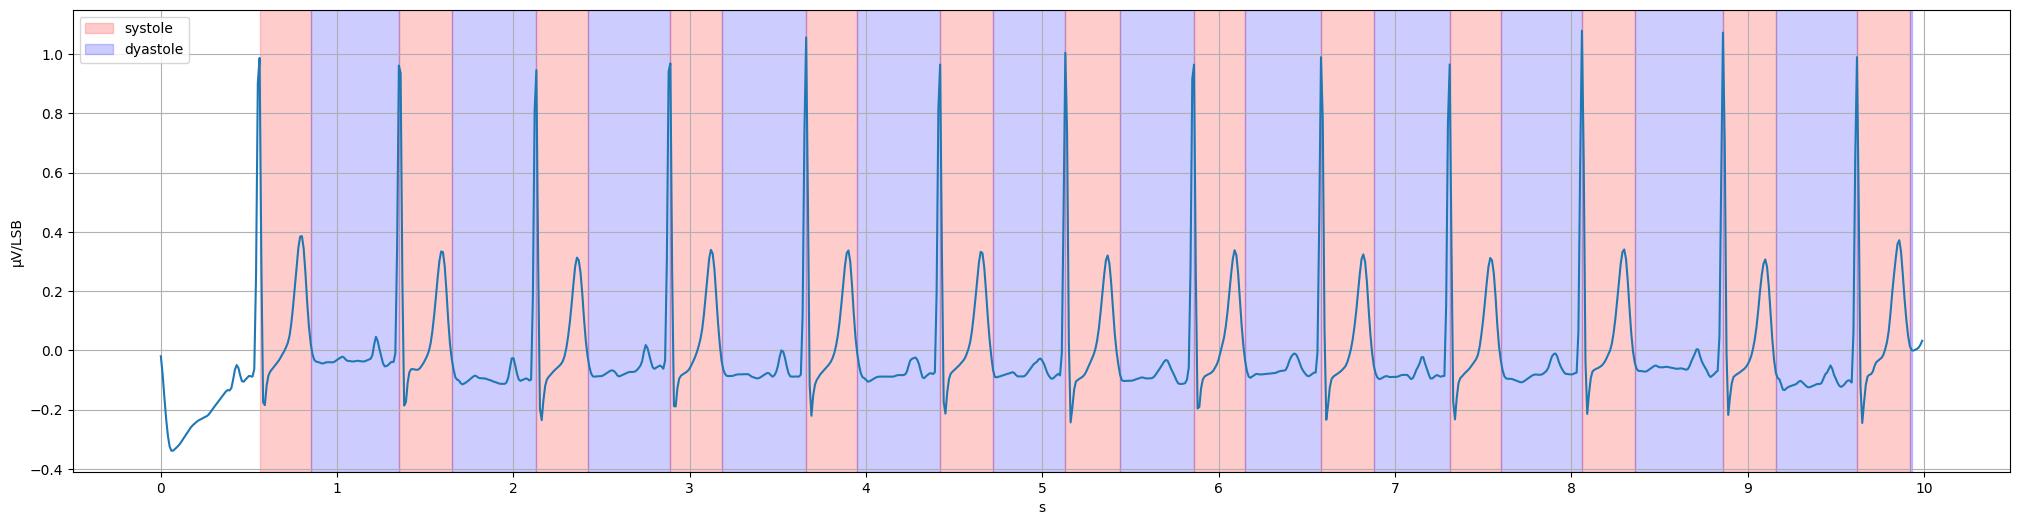

In [29]:
plot_cardiac_phase(cleaned)

# 4. Conclussions

## 4.1. Recap

With this document we have explored the PTB-XL dataset, which includes data of ECGs. This dataset can be considered for a classification problem if we want to predict the diagnosis usign the ECG signal data. The dataset is well-suited for a deep learning model, as the quantity of data is large. However, some problems might arise because of the distribution of the labels.

If we use the super-classes provided as labels, we would probably discard the data that does not fall under any of those superclasses, excluding those diagnosis from the model. There might be some problems because of the data unbalance, with the class _HYP_ having less samples than the others. Also, the common copling of the classes should be taken into account too.

Discovering this coupling is not only useful while making a classification model. Knowing that these diagnoses apprear together very often, experts can try to look for evidence of the common coupled illnesses when a diagnosis is made.

A plot of the ECG have been made with the aim of providing the expert visual access to the data. Annotations have been generated in the graphs that could be useful to facilitate the expert's task, including complex QRS and cardiac phases.

## 4.2. Future work

Visualizations could be improved with the feedback from experts. Also, if any specific annotation not covered in this project could be needed, it can be added.

A prediction model could be developed to predict diagnosis from the ECG data. There is enough data to use a deep learning model, which should consider the sequential nature of the data and therefore adapt the architecture to that fact using, for example, LSTMs. The imbalance in the dataset should be addressed. There is plenty of bibliography about is task, and should be further explored when designing the model.

If the model is used to diagnosis together with expert, it is important to apply explainable AI tools to show the expert how the model is taking decisions.

# 5. Bibliography

[PTB-XL, a large publicly available electrocardiography dataset](https://physionet.org/content/ptb-xl/1.0.2/)

[PTB-XL, a large publicly available electrocardiography dataset (extended documentation)](https://www.researchgate.net/publication/341618371_PTB-XL_a_large_publicly_available_electrocardiography_dataset)

[ECG R peak detection in Python: a comparison of libraries](https://www.samproell.io/posts/signal/ecg-library-comparison/)

[Deep Learning for ECG Analysis: Benchmarks and Insights from PTB-XL](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=9190034)

[QRS complex](https://en.wikipedia.org/wiki/QRS_complex)

[12-lead ECG](https://en.wikipedia.org/wiki/Electrocardiography)

[NeuroKit2 ECG package](https://neuropsychology.github.io/NeuroKit/functions/ecg.html)

[wfbd package](https://wfdb.readthedocs.io/en/latest/)

